<a href="https://colab.research.google.com/github/kosmo-tony/Optimization-methods/blob/master/Optimization_methods_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# The error accumulation in the conjugate gradient method for degenerate problem. Anton Ryabtsev. DCAM MIPT.

In [0]:
import numpy
import numpy as np
from numpy.random import rand
from numpy import Inf
import scipy.io
import time
import random
import matplotlib as mpl
from matplotlib import pyplot as plt
from scipy.stats import special_ortho_group
import scipy.optimize
from scipy.sparse import linalg
from google.colab import files
from scipy.optimize import minimize
                   

from copy import deepcopy

# Spectre generation

In [0]:
def generate_spectre(n1, n2, size, eps):    
    spectre = []
    for i in range(size//2):
        noise = random.uniform(-eps, eps)        
        spectre = [n1 + noise] + spectre
        noise = random.uniform(-eps, eps)
        spectre.append(n2 + noise)
    if size % 2 == 1:
        noise = random.uniform(-eps, eps)
        spectre.append(n2 + noise)
    return spectre

# Plotting spectre

In [0]:
def plot_spectrum(coordinates):
    
    # Draw horizontal line
    plt.hlines(0, np.min(coordinates) - 1, np.max(coordinates) + 1)
    plt.xlim(np.min(coordinates) - 1, np.max(coordinates) + 1)
    plt.ylim(-0.5, 0.5)
    
    # Draw eig-values points
    y = np.zeros(np.shape(coordinates))
    plt.plot(coordinates, y, '|', label="Eigenvalues", ms = 10)
    plt.xlabel('Eigenvalues', fontsize=15)
    fig = plt.gcf()
    fig.set_size_inches(20, 2.2)
    plt.legend(loc="best", fontsize=12)
    plt.yticks([])
    plt.savefig('Spectrum.pdf')
    plt.show()

# Generating function and gradient

In [0]:
def qf_params(A, b, n, M_inv=None):
    if (np.array_equal(A, A.T) == False):
        A = 0.5 * (A + A.T)
    return {'f': lambda x: 0.5 * (x.T @ A @ x) - b.T @ x, 'grad': lambda x: 0.5 * (A + A.T) @ x - b, 'n': n}

# Creating noisy matrixes and vecs

## Noisy vector generation

$\|b\|_2 = \sqrt{b_1^2 + b_2^2 + ... + b_n^2}$

$\|\tilde{b} - b\|_2 = \sqrt{(\tilde{b}_1 - b_1)^2 + (\tilde{b}_2 - b_2)^2 + ... + (\tilde{b}_n - b_n)^2} < \delta_b$

$\|\tilde{b} - b\|_2 = \sqrt{\Delta_1^2 + \Delta_2^2 + ... + \Delta_n^2} < \delta_b$

$\Delta_1^2 + \Delta_2^2 + ... + \Delta_n^2 < \delta_b^2$

$\Delta_1 = random.uniform(-\delta_b, \delta_b)$

$\Delta_2 = random.uniform(-\sqrt{\delta_b^2 - \Delta_1^2}, \sqrt{\delta_b^2 - \Delta_1^2})$

$\Delta_3 = random.uniform(-\sqrt{\delta_b^2 - \Delta_1^2 - \Delta_2^2}, \sqrt{\delta_b^2 - \Delta_1^2 - \Delta_2^2})$

...

## Noisy matrix generation

$
\|\tilde{A} - A\|_2 < \delta_A
$

$
\tilde{A} = A + \delta\cdot I, 
$

$
\tilde{A} - A = \delta\cdot I
$

$
\|\delta\cdot I\|_2 < \delta_A
$

$
0 < \delta < \delta_A
$

$
\delta = random.uniform(0, \delta_A)\;\;\; or \;\;\; \delta = random.gauss(0, \frac{\delta_A}{3})
$

In [0]:
def make_noisy_object(linspace_object, delta):
    if len(linspace_object.shape) == 2: # means that object is a matrix        
        I = np.eye(linspace_object.shape[0])        
        d = random.uniform(-delta, delta)
#         d = random.gauss(0, delta/3)
        dI = d * I        
        noisy_linspace_object = linspace_object + dI
        
    else:
        deltas = np.zeros(len(linspace_object))
        deltas[0] = (np.random.uniform(-delta, delta))
        i = 1
        while i < len(linspace_object) and np.sum(np.array(deltas)**2) < delta**2:
            deltas[i] = (np.random.uniform(-np.sqrt(delta**2 - np.sum(np.array(deltas)**2)),\
                                           np.sqrt(delta**2 - np.sum(np.array(deltas)**2))))
            i += 1
                     
        noisy_linspace_object = linspace_object + deltas
    
    return noisy_linspace_object

# My solver

In [0]:
class CG_solver():
    def __init__(self, starter_A, starter_b, accuracy=10**-3, factor=10, A=None, b=None):        
        func = qf_params(starter_A, starter_b, starter_A.shape[0])
        self.accuracy = accuracy
        self.factor = factor
        if A is not None:
            self.A = A
            self.starter_A = starter_A
        else:
            self.A = starter_A
        if b is not None:
            self.b = b
            self.starter_b = starter_b
        else:
            self.b = starter_b
        func = qf_params(self.A, self.b, self.A.shape[0])
        self.f = func['f']
        self.grad = func['grad']
        self.n = func['n']

        self.d = -func['grad'](x0)
        self.alpha = 0
    
    def calculate_alpha(self, x):
        d = self.d
        grad = self.grad
        alpha = -float(d.T @ grad(x)) / float(d.T @ self.A @ d)
        return alpha
    
    def calculate_beta(self, x, dx):
        d = self.d
        grad = self.grad
        beta = float(grad(x) @ self.A @ d) / float(d.T @ self.A @ d)        
        return beta
    
    def solve(self, x0, save_trajectory=True, variable_tilde_A=False, variable_tilde_b=False,\
              delta_A=None, delta_b=None):        
        g = self.grad(x0)
        i = 0
        errors = []
        trajectory = []
        gradient_traj = []
        gradient_traj.append(np.linalg.norm(g, ord=2))
        trajectory.append(deepcopy(x0))
        x = deepcopy(x0)
        
        while(np.linalg.norm(g, ord=2) > self.accuracy and i < self.n * self.factor):
            if (i+1) % 500 == 0: print(f'i: {i+1}')
            i += 1
            dx = self.calculate_alpha(x) * self.d            
            x += dx       
            g = self.grad(x)
            gradient_traj.append(np.linalg.norm(g, ord=2))
            beta = self.calculate_beta(x, dx)
            self.d = -g + beta * self.d
            if variable_tilde_A:
                self.A = make_noisy_object(self.starter_A, delta_A)
            if variable_tilde_b:
                self.b = make_noisy_object(self.starter_b, delta_b)                
            if (variable_tilde_A or variable_tilde_b):
                func = qf_params(self.A, self.b, self.A.shape[0])
                self.f = func['f']
                self.grad = func['grad']
            trajectory.append(deepcopy(x))
        print(f'{i} iterations')
        if save_trajectory:
            return {'trajectory' : trajectory, 'grad' : gradient_traj, "num_iter": i}
        else:
            return {'x' : self.x, "num_iter": i}

# 1.  $N = 10$, noise $\delta = 10^{-5}$

In [0]:
N = 10
spectre = generate_spectre(0.1, 130000, int(N), 0.08)
di = np.diag(spectre)


x = special_ortho_group.rvs(N)

In [207]:
B = x @ di @ x.T
b = rand(B.shape[0])
print(f'Det: {np.linalg.slogdet(B)[1]}, cond: {np.linalg.cond(B)}')

Det: 46.49888661976414, cond: 2512597.140076053


In [0]:
func1 = qf_params(B, b, B.shape[0])

x0 = np.zeros(func1['n'])
# x0 = np.random.uniform(-100, 100, func1['n'])

In [209]:
solver1 = CG_solver(B, b)
res1 = solver1.solve(x0)

8 iterations


In [0]:
noisy_B = make_noisy_object(B, 10**-5)
noisy_b = make_noisy_object(b, 10**-5)

func2 = qf_params(noisy_B, b, noisy_B.shape[0])

In [0]:
solver2 = CG_solver(starter_A=B, starter_b=b, factor=10000, A=noisy_B, b=noisy_b)

In [248]:
res2 = solver2.solve(x0, variable_tilde_A=True, variable_tilde_b=True, delta_A=10**-5, delta_b=10**-5)
# res2 = solver2.solve(x0, variable_tilde_A=True, variable_tilde_b=False, delta_A=10**-5)

30 iterations


In [249]:
print(f"orig  f*: {func1['f'](res1['trajectory'][-1])}\nnoisy f*: {func1['f'](res2['trajectory'][-1])}\nerror: {np.abs(func1['f'](res2['trajectory'][-1]) - func1['f'](res1['trajectory'][-1]))}")

orig  f*: -11.314031194967589
noisy f*: -11.314030117410127
error: 1.0775574619259487e-06


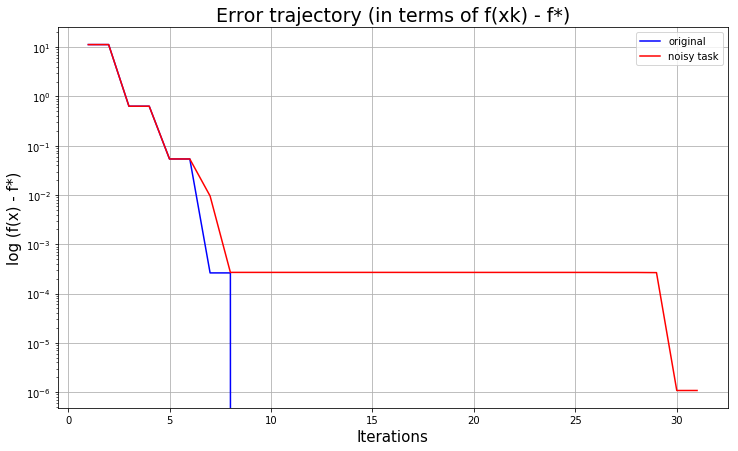

In [250]:
f_min = min(func1['f'](res1['trajectory'][-1]), func1['f'](res2['trajectory'][-1]))

f = plt.figure(figsize=(12,7))
plt.semilogy(np.linspace(1, len(res1['trajectory']), len(res1['trajectory'])), [np.abs(func1['f'](res1['trajectory'][i]) - f_min) for i in range(len(res1['trajectory']))], color='b', label='original')
plt.semilogy(np.linspace(1, len(res2['trajectory']), len(res2['trajectory'])), [np.abs(func1['f'](res2['trajectory'][i]) - f_min) for i in range(len(res2['trajectory']))], color='r', label='noisy task')
plt.title('Error trajectory (in terms of f(xk) - f*)', fontsize=19)
plt.xlabel('Iterations', fontsize=15)
plt.ylabel('log (f(x) - f*)', fontsize=15)
plt.grid()
plt.legend()
plt.show()
f.savefig("res_10_5.pdf", bbox_inches='tight')

## Gradient trajectory: 

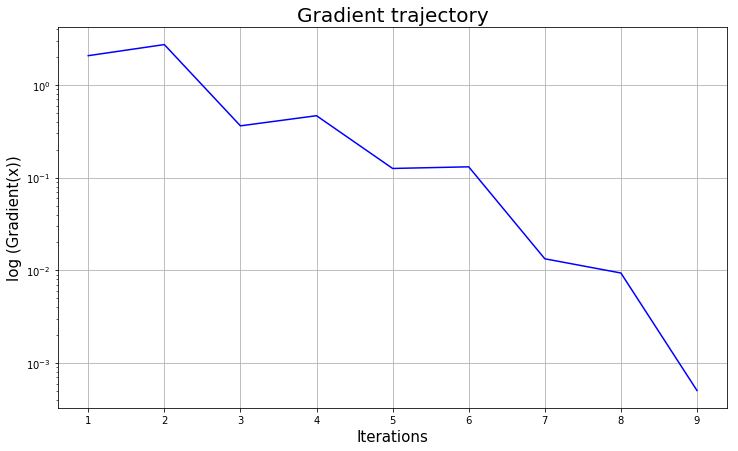

In [254]:
f = plt.figure(figsize=(12,7))
plt.semilogy(np.linspace(1, len(res1['trajectory']), len(res1['trajectory'])), [np.linalg.norm(func1['grad'](res1['trajectory'][i])) for i in range(len(res1['trajectory']))], color='b')
plt.title('Gradient trajectory', fontsize=20)
plt.xlabel('Iterations', fontsize=15)
plt.ylabel('log (Gradient(x))', fontsize=15)
plt.grid()
plt.show()
f.savefig("grad_10_5.pdf", bbox_inches='tight')

## Gradient trajectory for noisy task: 

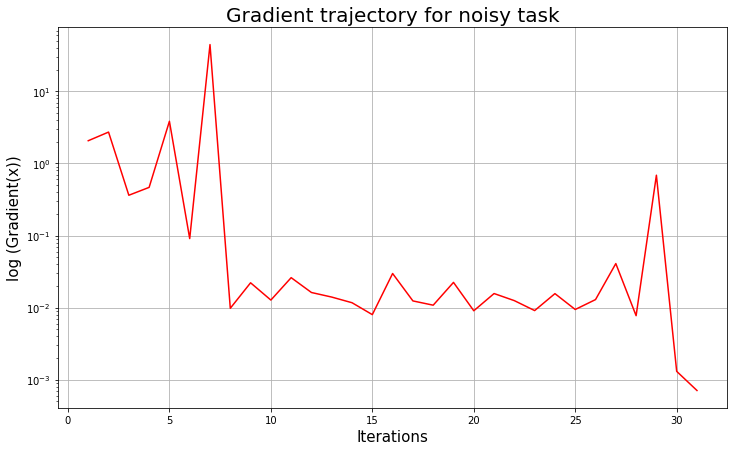

In [252]:
f = plt.figure(figsize=(12,7))
plt.semilogy(np.linspace(1, len(res2['grad']), len(res2['grad'])), res2['grad'], color='r')
plt.title('Gradient trajectory for noisy task', fontsize=20)
plt.xlabel('Iterations', fontsize=15)
plt.ylabel('log (Gradient(x))', fontsize=15)
plt.grid()
plt.show()
f.savefig("grad_n_10_5.pdf", bbox_inches='tight')

In [253]:
func = qf_params(B, b, B.shape[0])
res = minimize(func['f'], x0, method='CG', jac=func['grad'], options={'disp': True})

         Current function value: -11.313797
         Iterations: 8
         Function evaluations: 110
         Gradient evaluations: 98


# 2. $N = 100$; noise $\delta = 10^{-6}$

In [0]:
N = 100
spectre = generate_spectre(0.1, 130000, int(N), 0.08)
di = np.diag(spectre)


x = special_ortho_group.rvs(N)

In [256]:
B = x @ di @ x.T
b = rand(B.shape[0])
print(f'Det: {np.linalg.slogdet(B)[1]}, cond: {np.linalg.cond(B)}')

Det: 467.5920081049028, cond: 6071030.667504912


In [0]:
func1 = qf_params(B, b, B.shape[0])

x0 = np.zeros(func1['n'])
# x0 = np.random.uniform(-100, 100, func1['n'])

In [258]:
solver1 = CG_solver(B, b)
res1 = solver1.solve(x0)

25 iterations


In [0]:
noisy_B = make_noisy_object(B, 10**-6)
noisy_b = make_noisy_object(b, 10**-6)

func1= qf_params(noisy_B, noisy_b, noisy_B.shape[0])

In [0]:
solver2 = CG_solver(starter_A=B, starter_b=b, factor=150, A=noisy_B, b=noisy_b)

In [261]:
res2 = solver2.solve(x0, variable_tilde_A=True, variable_tilde_b=True, delta_A=10**-6, delta_b=10**-6)
# res2 = solver2.solve(x0, verbose=False, variable_tilde_A=False, variable_tilde_b=True, delta_b=10**-1)

i: 500
i: 1000
i: 1500
i: 2000
i: 2500
i: 3000
i: 3500
i: 4000
i: 4500
i: 5000
i: 5500
i: 6000
i: 6500
i: 7000
i: 7500
i: 8000
i: 8500
i: 9000
i: 9500
i: 10000
i: 10500
i: 11000
i: 11500
i: 12000
i: 12500
12794 iterations


In [262]:
print(f"orig  f*: {func1['f'](res1['trajectory'][-1])}\nnoisy f*: {func1['f'](res2['trajectory'][-1])}\nerror: {np.abs(func1['f'](res2['trajectory'][-1]) - func1['f'](res1['trajectory'][-1]))}")

orig  f*: -113.64543492525102
noisy f*: -113.64543269744834
error: 2.2278026818867147e-06


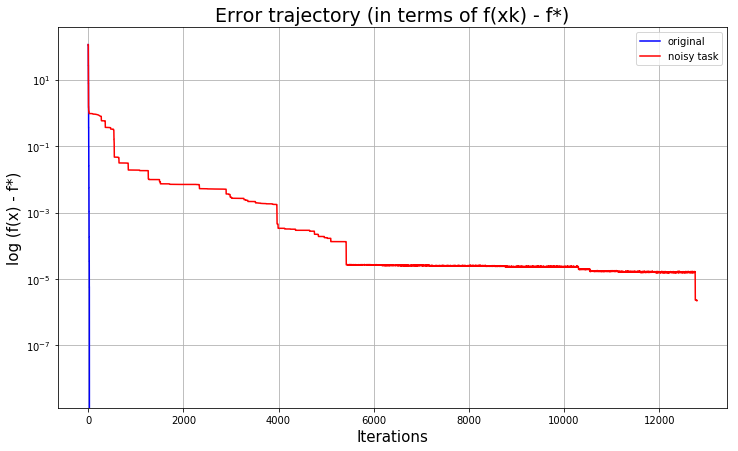

In [263]:
f_min = min(func1['f'](res1['trajectory'][-1]), func1['f'](res2['trajectory'][-1]))

f = plt.figure(figsize=(12,7))
plt.semilogy(np.linspace(1, len(res1['trajectory']), len(res1['trajectory'])), [np.abs(func1['f'](res1['trajectory'][i]) - f_min) for i in range(len(res1['trajectory']))], color='b', label='original')
plt.semilogy(np.linspace(1, len(res2['trajectory']), len(res2['trajectory'])), [np.abs(func1['f'](res2['trajectory'][i]) - f_min) for i in range(len(res2['trajectory']))], color='r', label='noisy task')
plt.title('Error trajectory (in terms of f(xk) - f*)', fontsize=19)
plt.xlabel('Iterations', fontsize=15)
plt.ylabel('log (f(x) - f*)', fontsize=15)
plt.grid()
plt.legend()
plt.show()
f.savefig("res_100_6.pdf", bbox_inches='tight')

In [190]:
func = qf_params(B, b, B.shape[0])
res = minimize(func['f'], x0, method='CG', jac=func['grad'], options={'disp': True})

         Current function value: -106.357285
         Iterations: 30
         Function evaluations: 137
         Gradient evaluations: 128


## Gradient trajectory: 

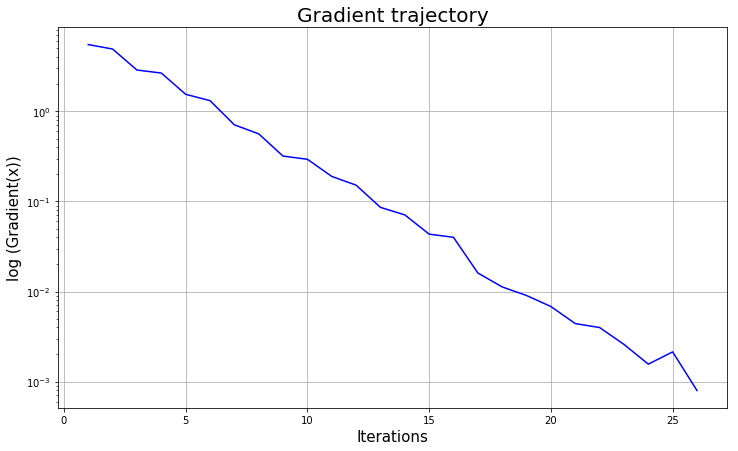

In [195]:
f = plt.figure(figsize=(12,7))
plt.semilogy(np.linspace(1, len(res1['trajectory']), len(res1['trajectory'])), [np.linalg.norm(func1['grad'](res1['trajectory'][i])) for i in range(len(res1['trajectory']))], color='b')
plt.title('Gradient trajectory', fontsize=20)
plt.xlabel('Iterations', fontsize=15)
plt.ylabel('log (Gradient(x))', fontsize=15)
plt.grid()
plt.show()
f.savefig("grad_100_6.pdf", bbox_inches='tight')

## Gradient trajectory for noisy task:

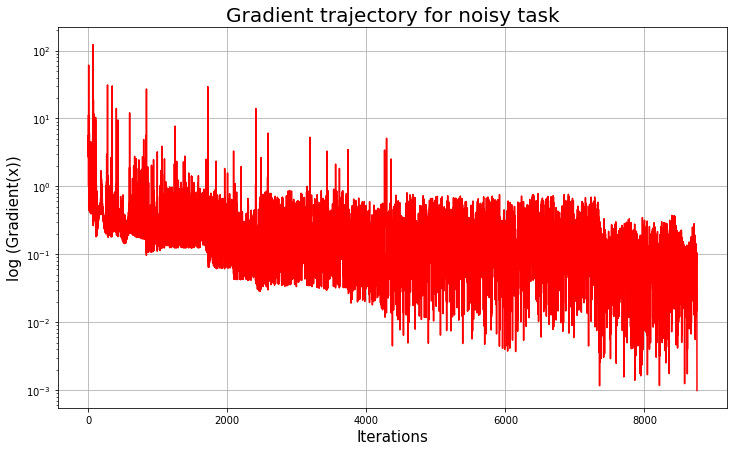

In [194]:
f = plt.figure(figsize=(12,7))
plt.semilogy(np.linspace(1, len(res2['grad']), len(res2['grad'])), res2['grad'], color='r')
plt.title('Gradient trajectory for noisy task', fontsize=20)
plt.xlabel('Iterations', fontsize=15)
plt.ylabel('log (Gradient(x))', fontsize=15)
plt.grid()
plt.show()
f.savefig("grad_n_100_6.pdf", bbox_inches='tight')

# 3. The same as (1.) but $x_0$ is a random point

In [0]:
N = 10
spectre = generate_spectre(0.1, 130000, int(N), 0.08)
di = np.diag(spectre)


x = special_ortho_group.rvs(N)

In [265]:
B = x @ di @ x.T
b = rand(B.shape[0])
print(f'Det: {np.linalg.slogdet(B)[1]}, cond: {np.linalg.cond(B)}')

Det: 46.85152164246243, cond: 3694654.4533012207


In [0]:
func1 = qf_params(B, b, B.shape[0])

# x0 = np.zeros(func1['n'])
x0 = np.random.uniform(-1000, 1000, func1['n'])

In [267]:
solver1 = CG_solver(B, b, accuracy=10**-5)
res1 = solver1.solve(x0)

12 iterations


In [0]:
noisy_B = make_noisy_object(B, 10**-5)
noisy_b = make_noisy_object(b, 10**-5)

func2 = qf_params(noisy_B, noisy_b, noisy_B.shape[0])

In [0]:
solver2 = CG_solver(starter_A=B, starter_b=b, accuracy=10**-6, factor=100000, A=noisy_B, b=noisy_b)

In [270]:
res2 = solver2.solve(x0, variable_tilde_A=True, variable_tilde_b=True, delta_A=10**-5, delta_b=10**-5)
# res2 = solver2.solve(x0, verbose=False, variable_tilde_A=False, variable_tilde_b=True, delta_b=10**-1)

i: 500
i: 1000
i: 1500
i: 2000
i: 2500
i: 3000
i: 3500
i: 4000
i: 4500
i: 5000
i: 5500
i: 6000
i: 6500
i: 7000
i: 7500
i: 8000
i: 8500
i: 9000
i: 9500
i: 10000
i: 10500
i: 11000
i: 11500
i: 12000
i: 12500
i: 13000
i: 13500
i: 14000
i: 14500
i: 15000
i: 15500
i: 16000
i: 16500
i: 17000
i: 17500
i: 18000
i: 18500
i: 19000
i: 19500
i: 20000
i: 20500
i: 21000
i: 21500
i: 22000
i: 22500
i: 23000
i: 23500
i: 24000
i: 24500
i: 25000
i: 25500
i: 26000
i: 26500
i: 27000
i: 27500
i: 28000
i: 28500
i: 29000
i: 29500
i: 30000
i: 30500
i: 31000
i: 31500
i: 32000
i: 32500
i: 33000
i: 33500
i: 34000
i: 34500
i: 35000
i: 35500
i: 36000
i: 36500
i: 37000
i: 37500
i: 38000
i: 38500
i: 39000
i: 39500
i: 40000
i: 40500
i: 41000
i: 41500
i: 42000
i: 42500
i: 43000
i: 43500
i: 44000
i: 44500
i: 45000
i: 45500
i: 46000
i: 46500
i: 47000
i: 47500
i: 48000
i: 48500
i: 49000
i: 49500
i: 50000
i: 50500
i: 51000
i: 51500
i: 52000
i: 52500
i: 53000
i: 53500
i: 54000
i: 54500
i: 55000
i: 55500
i: 56000
i: 56500
i: 

In [278]:
print(f"orig  f*: {func1['f'](res1['trajectory'][-1])}\nnoisy f*: {func1['f'](res2['trajectory'][-1])}\nerror: {np.abs(func1['f'](res2['trajectory'][-1]) - func1['f'](res1['trajectory'][-1]))}")

orig  f*: -5.107125161905918
noisy f*: -5.107125050070585
error: 1.1183533299430337e-07


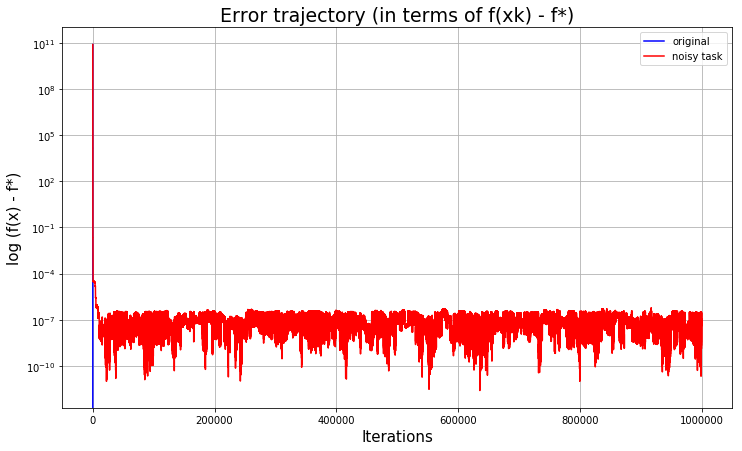

In [273]:
f_min = min(func1['f'](res1['trajectory'][-1]), func1['f'](res2['trajectory'][-1]))

f = plt.figure(figsize=(12,7))
plt.semilogy(np.linspace(1, len(res1['trajectory']), len(res1['trajectory'])), [np.abs(func1['f'](res1['trajectory'][i]) - f_min) for i in range(len(res1['trajectory']))], color='b', label='original')
plt.semilogy(np.linspace(1, len(res2['trajectory']), len(res2['trajectory'])), [np.abs(func1['f'](res2['trajectory'][i]) - f_min) for i in range(len(res2['trajectory']))], color='r', label='noisy task')
plt.title('Error trajectory (in terms of f(xk) - f*)', fontsize=19)
plt.xlabel('Iterations', fontsize=15)
plt.ylabel('log (f(x) - f*)', fontsize=15)
plt.grid()
plt.legend()
plt.show()
f.savefig("res_r_10_5.pdf", bbox_inches='tight')

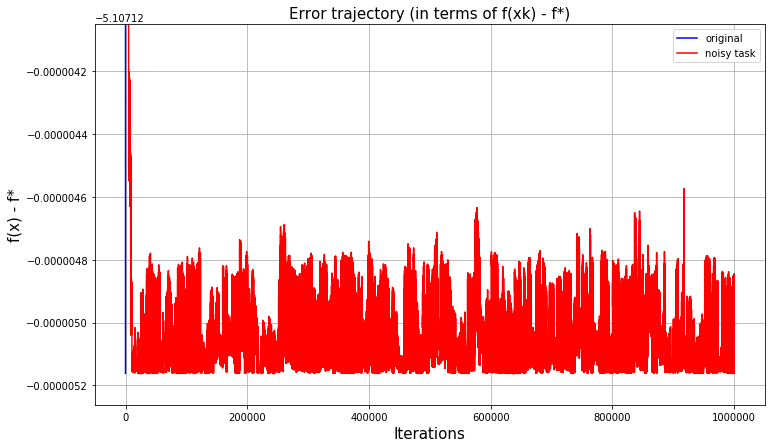

In [274]:
f = plt.figure(figsize=(12,7))
plt.plot(np.linspace(1, len(res1['trajectory']), len(res1['trajectory'])), [func1['f'](res1['trajectory'][i]) for i in range(len(res1['trajectory']))], color='b', label='original')
plt.plot(np.linspace(1, len(res2['trajectory']), len(res2['trajectory'])), [func1['f'](res2['trajectory'][i]) for i in range(len(res2['trajectory']))], color='r', label='noisy task')
plt.ylim(func1['f'](res1['trajectory'][-1]) - 0.0000001, func1['f'](res2['trajectory'][-1]) + 0.000001)
plt.title('Error trajectory (in terms of f(xk) - f*)', fontsize=15)
plt.xlabel('Iterations', fontsize=15)
plt.ylabel('f(x) - f*', fontsize=15)
plt.grid()
plt.legend()
plt.show()

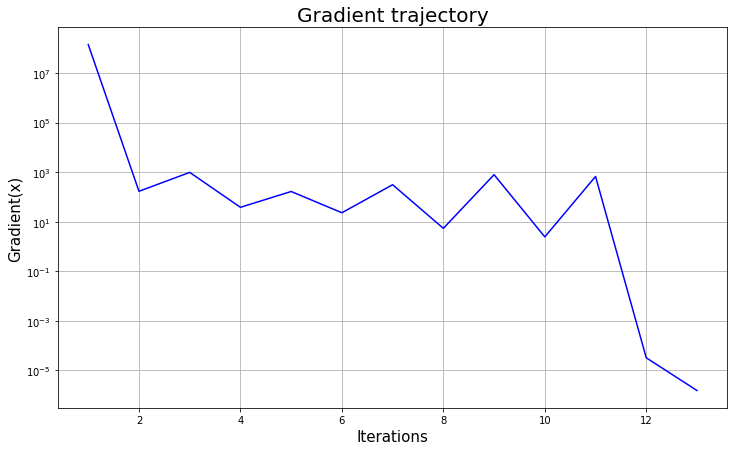

In [276]:
f = plt.figure(figsize=(12,7))
plt.semilogy(np.linspace(1, len(res1['trajectory']), len(res1['trajectory'])), [np.linalg.norm(func1['grad'](res1['trajectory'][i])) for i in range(len(res1['trajectory']))], color='b')
plt.title('Gradient trajectory', fontsize=20)
plt.xlabel('Iterations', fontsize=15)
plt.ylabel('Gradient(x)', fontsize=15)
plt.grid()
plt.show()
f.savefig("grad_r_10_5.pdf", bbox_inches='tight')

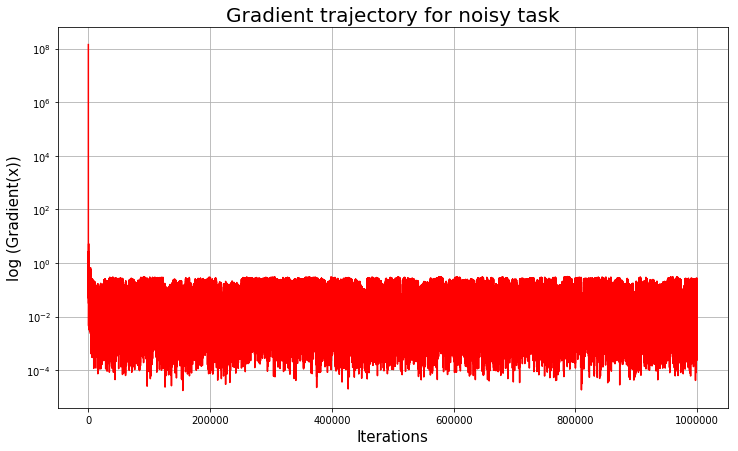

In [277]:
f = plt.figure(figsize=(12,7))
plt.semilogy(np.linspace(1, len(res2['grad']), len(res2['grad'])), res2['grad'], color='r')
plt.title('Gradient trajectory for noisy task', fontsize=20)
plt.xlabel('Iterations', fontsize=15)
plt.ylabel('log (Gradient(x))', fontsize=15)
plt.grid()
plt.show()
f.savefig("grad_r_n_10_5.pdf", bbox_inches='tight')